<h1 style="font-size:30px;">Load Custom Datasets in PyTorch</h1>

Till now, we have experimented with datasets available with the PyTorch Torchvision library.

In this notebook, we will see how to load raw images present in a folder.

Data available in torchvision-datasets are preprocessed images. But in the real world, we have to do it on our own.

To illustrate a few preprocessing, we have chosen the [10 Monkey Species](https://www.kaggle.com/slothkong/10-monkey-species) dataset from Kaggle. You can download the data from [here](https://www.kaggle.com/slothkong/10-monkey-species/download). You need to extract data. We have already uploaded the extracted data in the lab.

**Label mapping:**

| Label | Monkey Species |
| --- | --- |
| n0 | alouatta_palliata |
| n1 | erythrocebus_patas |
| n2 | cacajao_calvus |
| n3 | macaca_fuscata |  
| n4 | cebuella_pygmea |
| n5 | cebus_capucinus |
| n6 | mico_argentatus |
| n7 | saimiri_sciureus |
| n8 | aotus_nigriceps |
| n9 | trachypithecus_johnii |


**Extracted Folder structure:**

```
data_root
├── training
│   └── training
│       ├── n0
│       ├── n1
│       ├── n2
│       ├── n3
│       ├── n4
│       ├── n5
│       ├── n6
│       ├── n7
│       ├── n8
│       └── n9
└── validation
    └── validation
        ├── n0
        ├── n1
        ├── n2
        ├── n3
        ├── n4
        ├── n5
        ├── n6
        ├── n7
        ├── n8
        └── n9

```

`data_root/training/training` has `n0-n9` folders; each folder has images of the corresponding class. Similarly, `data_root/validation/validation` has `n0-n9` folders.


**PyTorch has inbuilt functionality (`torchvision.datasets.ImageFolder` class) to load such structured image folders:**

```
torchvision.datasets.ImageFolder(root, transform=None, target_transform=None, loader=<function default_loader>, is_valid_file=None)
```
You should notice the similarity of the above with torchvision.datasets.MNIST. This is because both belong to the same dataset class.

This is a generic data loader where the images are arranged in this way:

```
root/n0/xxx.png
root/n0/xxy.jpg
root/n0/xxz.png

root/n1/123.jpg
root/n1/nsdf3.png
root/n1/asd932_.png

    :
    :
    
root/n9/1b23.jpg
root/n9/nsasdf3.png
root/n9/as2wdd932_.png
    
```

Parameters:

- `root` (string) – Root directory path.

- `transform` (callable, optional) – A function/transform that takes in an PIL image and returns a transformed version. E.g, transforms.RandomCrop

- `target_transform` (callable, optional) – A function/transform that takes in the target and transforms it.

- `loader` (callable, optional) – A function to load an image given its path.

- `is_valid_file` – A function that takes path of an Image file and check if the file is a valid file (used to check of corrupt files).

Find more details [here](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder).

## Table of Contents

* [1 Download and Extract Dataset](#1-Download-and-Extract-Dataset)
* [2 Explore Training Data](#2-Explore-Training-Data)
* [3 Dataset with Preprocessing](#3-Dataset-with-Preprocessing)
* [4 Dataloader with ImageFolder Dataset](#4-Dataloader-with-ImageFolder-Dataset)

In [1]:
import os
import sys
import requests
import random
from zipfile import ZipFile, BadZipFile


import numpy as np
import torch

import matplotlib.pyplot as plt

from torchvision import datasets, transforms

In [2]:
def system_config(SEED_VALUE=42, package_list=None):
    """
    Configures the system environment for PyTorch-based operations.

    Args:
        SEED_VALUE (int): Seed value for random number generation. Default is 42.
        package_list (str): String containing a list of additional packages to install
        for Google Colab or Kaggle. Default is None.

    Returns:
        tuple: A tuple containing the device name as a string and a boolean indicating GPU availability.
    """

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)

    def is_running_in_colab():
        return 'COLAB_GPU' in os.environ

    def is_running_in_kaggle():
        return 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

    #--------------------------------
    # Check for availability of GPUs.
    #--------------------------------
    if torch.cuda.is_available():
        print('Using CUDA GPU')

        # This section for installing packages required by Colab.
        if is_running_in_colab() or is_running_in_kaggle():
            print('Installing required packages...')
            !pip install {package_list}

        # Set the device to the first CUDA device.
        DEVICE = torch.device('cuda')
        print("Device: ", DEVICE)
        GPU_AVAILABLE = True

        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)

        # Performance and deterministic behavior.
        torch.backends.cudnn.enabled = True       # Provides highly optimized primitives for DL operations.
        torch.backends.cudnn.deterministic = True # Insures deterministic even when above cudnn is enabled.
        torch.backends.cudnn.benchmark = False    # Setting to True can cause non-deterministic behavior.

    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        print('Using Apple Silicon GPU')

        # Set the device to the Apple Silicon GPU Metal Performance Shader (MPS).
        DEVICE = torch.device("mps")
        print("Device: ", DEVICE)
        # Environment variable that allows PyTorch to fall back to CPU execution
        # when encountering operations that are not currently supported by MPS.
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        GPU_AVAILABLE = True

        torch.mps.manual_seed(SEED_VALUE)
        torch.use_deterministic_algorithms(True)

    else:
        print('Using CPU')
        DEVICE = torch.device('cpu')
        print("Device: ", DEVICE)
        GPU_AVAILABLE = False

        if is_running_in_colab() or is_running_in_kaggle():
            print('Installing required packages...')
            !pip install {package_list}
            print('Note: Change runtime type to GPU for better performance.')

        torch.use_deterministic_algorithms(True)

    return str(DEVICE), GPU_AVAILABLE

In [3]:
DEVICE, GPU_AVAILABLE = system_config()

Using CPU
Device:  cpu
Installing required packages...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 5.0.2
    Uninstalling Sphinx-5.0.2:
      Successfully uninstalled Sphinx-5.0.2
Note: Change runtime type to GPU for better performance.


## 1 Download and Extract Dataset

In [4]:
def download_file(url, save_name):
    response = requests.get(url, stream=True)
    with open(save_name, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print(f"Downloaded: {save_name}")

In [5]:
def unzip(zip_file_path=None):
    try:
        with ZipFile(zip_file_path, 'r') as z:
            z.extractall("./")
            print(f"Extracted: {os.path.splitext(zip_file_path)[0]}\n")
    except FileNotFoundError:
        print("File not found")
    except BadZipFile:
        print("Invalid or corrupt zip file")
    except Exception as e:
        print(f"Error occurred: {e}")

    return

In [6]:
URL = r"https://www.dropbox.com/s/45jdd8padeyjq6t/10_Monkey_Species.zip?dl=1"

archive_name = "10_Monkey_Species"

zip_name = f"./{archive_name}.zip"

if not os.path.exists(archive_name):

    download_file(URL, zip_name)
    unzip(zip_name)

Downloaded: ./10_Monkey_Species.zip
Extracted: ./10_Monkey_Species



## 2 Explore Training Data

### 2.1 Load Data

In [8]:
# Load training data
# train_root = os.path.join("./10_Monkey_Species", "training", "training")
train_root = os.path.join("10_Monkey_Species", "training", "training")

train_data = datasets.ImageFolder(root=train_root)

### 2.2 Explore Data

**Get Classes**

In [9]:
# classes

train_data.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

**Class to Index Mapping**

In [10]:
# Class to index mappings

train_data.class_to_idx

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

**Data Length**

In [11]:
# data length

len(train_data)

1097

**Get Image and Target**

PIL image size: (500, 331), target: 0


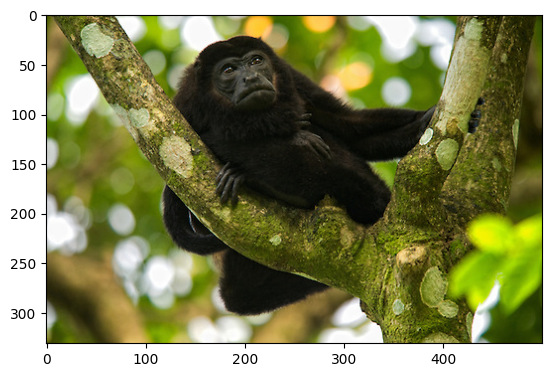

In [12]:
# get image and target

img, target = train_data[5]

print('PIL image size: {}, target: {}'.format(img.size, target))

plt.imshow(img)
plt.show()

**Note: In PIL image `size` attribute gives `width x height`**

image size: (400, 400), target: 4


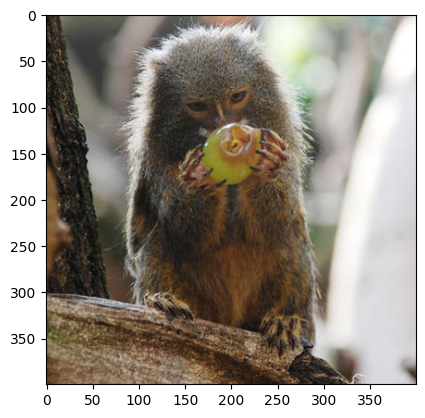

In [13]:
# get image and target
img, target = train_data[500]

print('image size: {}, target: {}'.format(img.size, target))

plt.imshow(img)
plt.show()

**We can see that different images have different sizes. For training, we need fixed-size images. So we can not use these images as they are for training. We can use `torchvision.transforms.Resize` to resize images.**

## 3 Dataset with Preprocessing

**Let's resized training data to `224 x 224`.**


In [14]:
# transform=transforms.Resize(224, 224)
train_data = datasets.ImageFolder(root=train_root, transform=transforms.Resize((224, 224)))


image size: (224, 224), target: 0


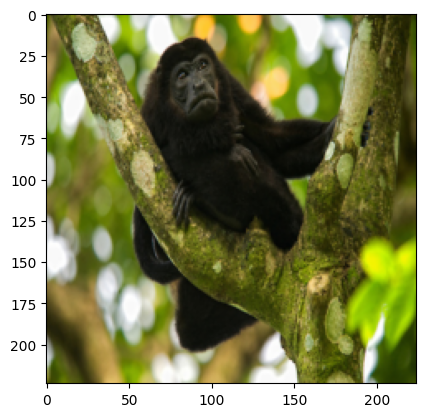

In [15]:
img, target = train_data[5]

print('image size: {}, target: {}'.format(img.size, target))

plt.imshow(img)
plt.show()

image size: (224, 224), target: 4


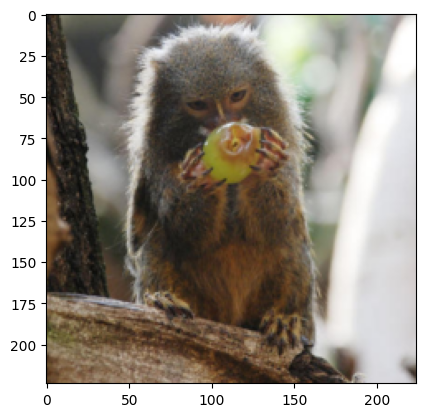

In [16]:
img, target = train_data[500]

print('image size: {}, target: {}'.format(img.size, target))

plt.imshow(img)
plt.show()

**We can see that directly resizing to `224 x 224` is distorting the image because aspect ratio (`width:height`) is not taken care of by this way of resizing.**

If we give an integer instead of a tuple as an argument to `transforms.resize`, it will resize lower pixel value to given integer value, and higher pixel value will be such that it will maintain aspect ratio.

**Let's have a look.**

image size: (338, 224), target: 0


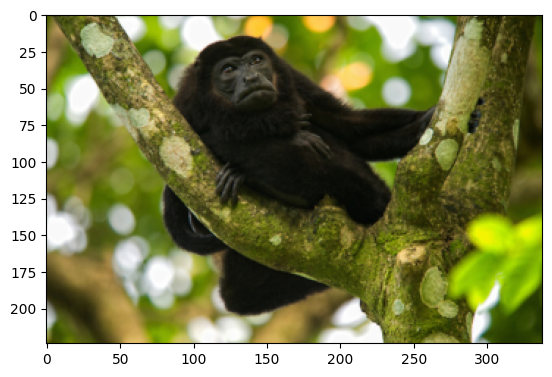

In [17]:
train_data = datasets.ImageFolder(root=train_root, transform=transforms.Resize(224))

img, target = train_data[5]

print('image size: {}, target: {}'.format(img.size, target))

plt.imshow(img)
plt.show()

**We can see height has a lower value, which resized to 224.**

## 4 Dataloader with ImageFolder Dataset

Suppose we need `224 x 224` sized images. Generally, the image of interest is at the center of the big image. So we can use the following transform:

```
transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
    ])
```

Let's write down `get_data` method, which will return the training and validation data loader.

In [18]:
def get_data(batch_size, data_root, num_workers=4):

    preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ])

    # train dataloader

    train_data_path = os.path.join(data_root, 'training', 'training')

    train_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(root=train_data_path, transform=preprocess),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    # test dataloader

    test_data_path = os.path.join(data_root, 'validation', 'validation')

    test_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(root=test_data_path, transform=preprocess),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

### <font style="color:green">Plot few Images</font>

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


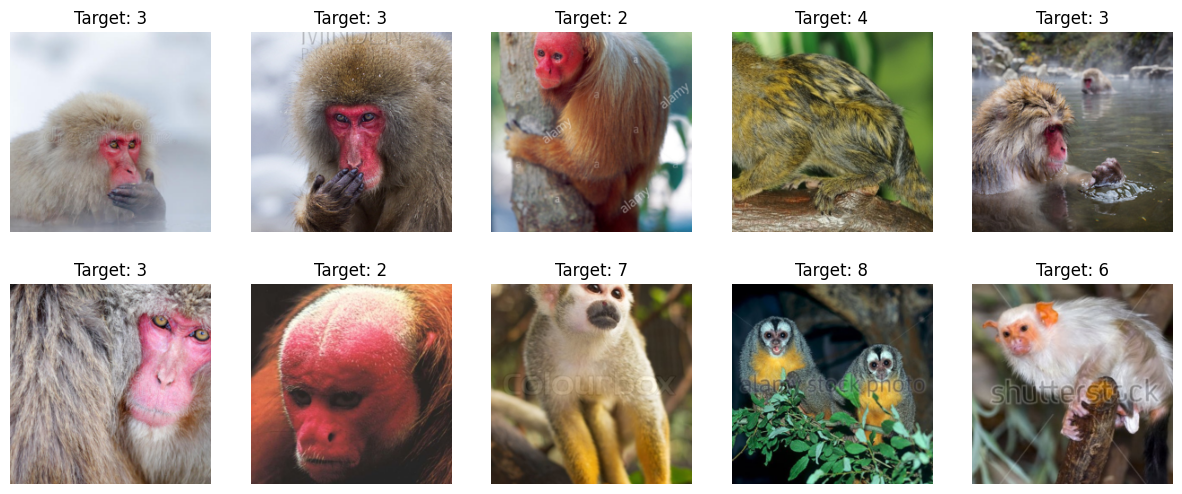

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [19]:
data_root = "10_Monkey_Species"

train_loader, test_loader = get_data(10, data_root)

plt.rcParams["figure.figsize"] = (15, 6)
plt.figure
for images, labels in train_loader:
    for i in range(len(labels)):
        plt.subplot(2, 5, i+1)
        img = transforms.functional.to_pil_image(images[i])
        plt.imshow(img)
        plt.axis('off')
        plt.gca().set_title('Target: {0}'.format(labels[i]))
    plt.show()
    break
